In [1]:
import re
import pymongo
from common import *
import pandas as pd

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

/home/salils/Documents/Python_n_R/Py_Projects/News_Summarization/properties.config
STAGE


In [2]:
df = pd.DataFrame.from_dict(news_data.find({}, {"_id": 0, "headlines": 1,	"text":1}))


df.rename(columns={"headlines": "summary"}, inplace=True)

In [3]:
df.shape

(36765, 2)

In [4]:
brief_cleaning1 = text_strip(df['text'])
brief_cleaning2 = text_strip(df['summary'])

In [5]:
!pip3 install spacy
!python3 -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [7]:
from time import time
import spacy

# disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

# Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000)]

# Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.29 mins


In [9]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.27 mins


In [10]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [11]:
text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

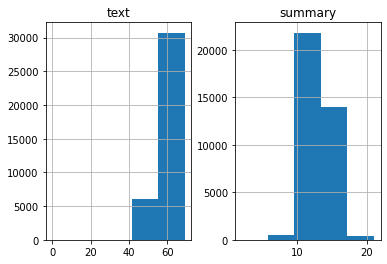

In [16]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [18]:
#Check how much % of summary have 0-15 words
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9027879776961785


In [20]:
#Check how much % of text have 0-70 words
cnt=0
for i in df['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(df['cleaned_text']))

1.0


In [21]:
!pip3 install numpy
import numpy as np

In [24]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

#Select the Summaries and Text between max len defined above

cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

post_pre.head(2)

,text,summary
0,indian equity benchmarks rallied on thursday l...,_START_ sensex jumps 000 points nifty crosses ...
1,shares of spicejet tanked as much as 10% on th...,_START_ spicejet shares hit 2-year low after a...


In [25]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [26]:
post_pre.head(5)

,text,summary
0,indian equity benchmarks rallied on thursday l...,sostok _START_ sensex jumps 000 points nifty c...
1,shares of spicejet tanked as much as 10% on th...,sostok _START_ spicejet shares hit 2-year low ...
2,amid report of lower inventories in the us and...,sostok _START_ oil price rises as russia cuts ...
3,meta has recorded its first ever quarterly dro...,sostok _START_ meta posts its first ever quart...
4,hcl technologies chairperson roshni nadar malh...,sostok _START_ who are the richest indian wome...


In [27]:
!pip install sklearn
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.4 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 14.4 MB/s eta 0:00:0000:0100:01


In [30]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 18.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 19.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━

In [32]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [33]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.19164619164619
Total Coverage of rare words: 2.0576364011692423
